# **Birds of a feather**

---
## Imports

In [1]:
from IPython.display import Audio
import librosa
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from scipy import ndimage

C:\Users\Parker\Miniconda3\envs\proj2\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\Parker\Miniconda3\envs\proj2\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


---
## Dataset collection

I used [Daniel Bolton's `youtube-dl` tool](https://github.com/ytdl-org/youtube-dl) to download a [YouTube playlist of bird songs](https://www.youtube.com/playlist?list=OLAK5uy_klzCEn-DkrdZyf6XTp8Bes9WA8dFGSaME).


Command used:

```
$ youtube-dl -x --audio-format wav --no-cache-dir -o '~/generative-audio-parker-audio/downloaded/%(playlist_index)s - %(title)s.%(ext)s' https://www.youtube.com/playlist?list=OLAK5uy_klzCEn-DkrdZyf6XTp8Bes9WA8dFGSaME
```

In [2]:
from IPython.display import Audio

In [ ]:
Audio("downloaded/10 - Nachtigall (Luscinia megarhynchos).wav")

I also downloaded the [Nanni et al. 2016 bird songs dataset](http://www.din.uem.br/yandre/birds/bird_songs_46.tar.gz) referenced in [this paper by Mangalam Sankupellay and Dmitry Konovalov](https://www.acoustics.asn.au/conference_proceedings/AAS2018/papers/p134.pdf).

Note that these are loops of single syllables.

In [2]:
Audio("bird_songs_46/fold1/11-558.wav")

---
## Audio &rarr; Spectrogram

In [3]:
import librosa

In [4]:
samples, sample_rate = librosa.load("downloaded/10 - Nachtigall (Luscinia megarhynchos).wav")

In [5]:
sample_rate

22050

In [6]:
samples.shape

(4065870,)

In [7]:
S = librosa.feature.melspectrogram(y=samples, sr=sample_rate)

In [8]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np

In [9]:
def show_spectro(S, sr=22050, to_file=False, figsize=(10,4), dpi=None):
    
    plt.figure(figsize=figsize)
    S_dB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_dB, x_axis='time',
                             y_axis='mel', sr=sr,
                             fmax=8000)
    
    if to_file:
        plt.axis(False)
    else:
        plt.colorbar(format='%+2.0f dB')
        plt.title('Mel-frequency spectrogram')
        plt.tight_layout()
        plt.show()

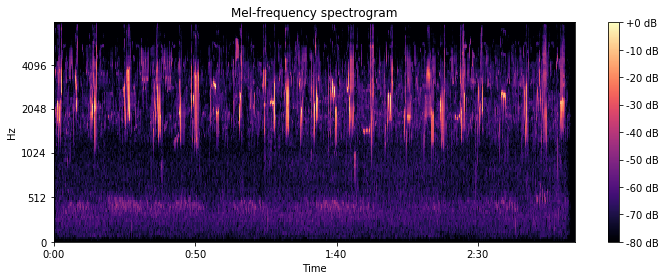

In [10]:
show_spectro(S)

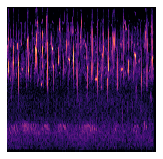

In [11]:
show_spectro(S, to_file="fp", figsize=(256/96, 256/96), dpi=96)

---
## Spectrogram &rarr; Audio

In [12]:
S.shape

(128, 7942)

In [13]:
%%time

#! NOTE: Takes a long time to inverse especially if the signal is complex.
#  (side note, for some reason each time I restart my datahub instance,
#   the amount of time this cell takes changes... was 22sec the
#   first time I tried, then 4min after a restart, and now 70sec...)
#
#  This should be fine since we're only going to be generating the output
#  at the end of the project, so we can leave it running!
inv = librosa.feature.inverse.mel_to_audio(S[:,:100])

CPU times: user 27.3 s, sys: 2min 30s, total: 2min 58s
Wall time: 22.6 s


In [14]:
inv

array([ 6.8012841e-06,  2.0267578e-05,  4.4904951e-05, ...,
       -1.5140010e-02, -7.2422750e-02, -9.6363313e-02], dtype=float32)

In [ ]:
# Audio(inv, rate=sample_rate)

---
## Convert dataset to training set

We're going to need to convert all of those wav files into rolling-window spectrograms.

In [15]:
len(inv) / sample_rate

2.2987755102040817

In [16]:
sample_rate / 512

43.06640625

In [17]:
# Note that every ~43 columns of my spectrogram S is a second of audio.


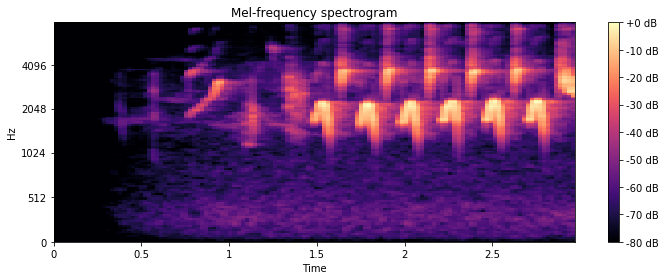

In [18]:
show_spectro(S[:,:128])

In [19]:
S[:,:128].shape

(128, 128)

In [20]:
print(S.max(), S.min())

544.30505 0.0


In [21]:
# This produces a cool looking visualization.
# I'll look into visualizations later if I have the time.

# plt.plot(S);

In [22]:
S_dB = librosa.power_to_db(S, ref=np.max)
S_dB[:,:128]

array([[-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
        -80.      ],
       [-80.      , -80.      , -80.      , ..., -80.      , -79.40505 ,
        -80.      ],
       [-80.      , -80.      , -80.      , ..., -76.08479 , -77.28459 ,
        -76.81924 ],
       ...,
       [-80.      , -80.      , -80.      , ..., -53.38407 , -57.441128,
        -58.110607],
       [-80.      , -80.      , -80.      , ..., -57.713238, -61.782417,
        -62.604042],
       [-80.      , -80.      , -80.      , ..., -65.61616 , -69.496544,
        -73.792076]], dtype=float32)

In [23]:
print(S_dB.max(), S_dB.min())

1.9073486e-06 -80.0


In [24]:
def wav_to_db_spectro(fp, **kwargs):
    """
    Converts a wav file into a decibel spectrogram.
    
    :param fp: Filepath for the wav file.
    :type fp: str
    :param **kwargs: Optional keyword arguments for `librosa.feature.melspectrogram(...)`
    :returns: Decibel spectrogram
    :rtype: np.ndarray
    """
    
    samples, sample_rate = librosa.load(fp)
    
    S = librosa.feature.melspectrogram(y=samples, sr=sample_rate)
    
    S_dB = librosa.power_to_db(S, ref=np.max)
    
    return np.clip(S_dB, -80.0, 0.0)

In [25]:
def show_db_spectro(S_dB, **kwargs):
    
    fig = plt.figure(**kwargs)
    
    librosa.display.specshow(S_dB, x_axis='time',
                             y_axis='mel',
                             fmax=8000)
    
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-frequency spectrogram')
    plt.tight_layout()
#     plt.show()
    
    return fig

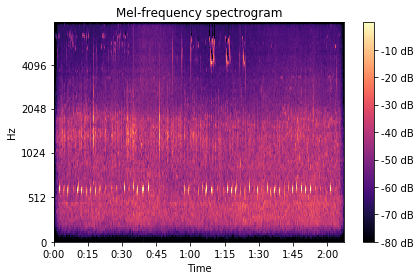

In [26]:
show_db_spectro(wav_to_db_spectro("downloaded/07 - Wiedehopf (Upupa epops).wav"));

In [27]:
# Audio("downloaded/07 - Wiedehopf (Upupa epops).wav")

In [28]:
sdb = wav_to_db_spectro("downloaded/10 - Nachtigall (Luscinia megarhynchos).wav")

In [29]:
# Audio("downloaded/10 - Nachtigall (Luscinia megarhynchos).wav")

In [30]:
def create_splits(S, stride=128):
    """
    Splits a decibel spectrogram into 128x128 slices with optional window overlap.
    Drops the last window if it doesn't contain 128 bands.
    
    .. todo:: Implement stride to allow overlapping windows.
    """
    
    #! TODO: Support overlapping windows
    splits = np.split(sdb, range(128, sdb.shape[1], 128), axis=1)
    
    if splits[-1].shape[1] < 128:
        splits = splits[:-1]
        
    return splits

In [31]:
splits = create_splits(sdb)

In [32]:
len(splits)

62

In [33]:
splits[-1].shape

(128, 128)

In [34]:
splits[0].shape

(128, 128)

In [35]:
s = librosa.db_to_power(splits[1])
inv = librosa.feature.inverse.mel_to_audio(s)

In [36]:
# Audio(inv, rate=sample_rate)

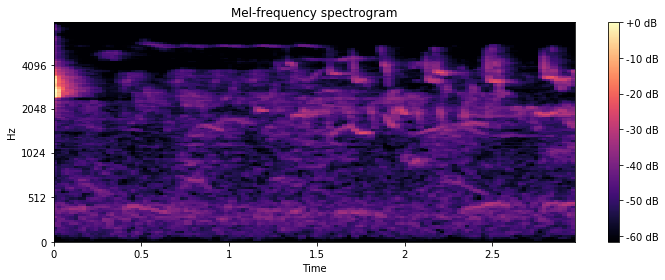

In [37]:
show_spectro(s)

In [38]:
import os

In [39]:
def save_spectrogram_splits(fp, outdir="spectrograms/splits/"):
    
    name = fp.split(' - ')[1].split(' ')[0]

    song = wav_to_db_spectro(fp)

    splits = create_splits(song)

    for idx, split in enumerate(splits):

        outfp = os.path.join(outdir, f"{name}{idx:03d}.npy")

        np.save(outfp, split)

In [40]:
import glob

In [41]:
done = True

if not done:

    for fp in glob.glob("downloaded/*"):

        save_spectrogram_splits(fp)

---
## Data Cleaning

Before training an autoencoder on the spectrograms, we should clean them up a bit.  My ideas are as follows:
- Remove spectrograms that are mostly silence — either drop sample if the max or average dB doesn't exceed some threshold.
- Denoise/increase contrast between main birdsong and background — there may be an easy denoising or contrast filter that I can apply (would need to play with the parameters)

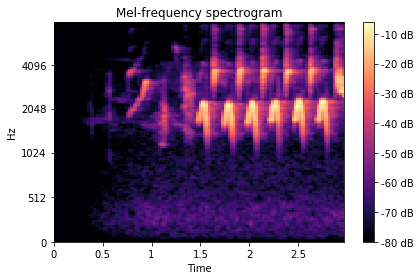

In [43]:
show_db_spectro(splits[0]);

In [44]:
# i = 0
# Audio(samples[sample_rate*i*3:sample_rate*(i+1)*3], rate=sample_rate)

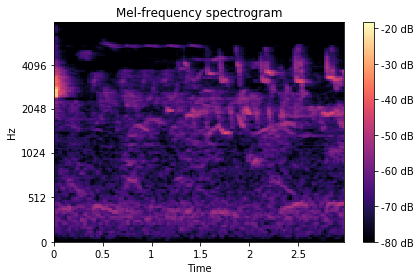

In [45]:
show_db_spectro(splits[1]);

In [46]:
# i = 1
# Audio(samples[sample_rate*i*3:sample_rate*(i+1)*3], rate=sample_rate)

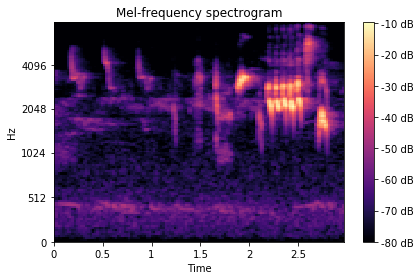

In [47]:
show_db_spectro(splits[2]);

In [48]:
# i = 2
# Audio(samples[sample_rate*i*3:sample_rate*(i+1)*3], rate=sample_rate)

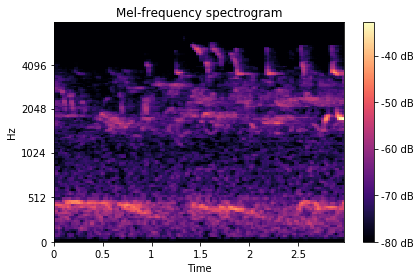

In [49]:
show_db_spectro(splits[3]);

In [50]:
# i = 3
# Audio(samples[sample_rate*i*3:sample_rate*(i+1)*3], rate=sample_rate)

In [51]:
# Idea:
#
# - create a classifier to find the ideal threshold
# - label a handful of splits manually as keep or toss, then train
#   a classifier which weights the max, mean, and variance of the
#   values

In [52]:
done = True

if not done:
    for idx, split in enumerate(splits):
        fig = show_db_spectro(split)
        plt.title(idx);

In [55]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

    
temp = """9
        0
        9
        0
        9
        9
        9
        9
        9
        9
        9
        9
        9
        9
        9
        9
        9
        9
        9
        9
        0
        9
        9
        9
        0
        9
        9
        9
        9
        9
        0
        9
        9
        9
        0
        9
        9
        9
        9
        9
        9
        9
        9
        9
        9
        9
        9
        9
        9
        9
        9
        0
        9
        9
        9
        9
        9
        9
        9
        9
        9
        0"""

tmp = temp.split('\n')

labels = [bool(int(elem)) for elem in tmp]

y = np.array(labels)

In [53]:
def features(data):
    return [np.array([
        d.mean(), d.max(), d.var()
    ]) for d in data]

In [56]:
X = features(splits)

In [57]:
y.mean()

0.8709677419354839

In [58]:
clf_logr = LogisticRegression(class_weight="balanced")

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [60]:
clf_logr.fit(X_train, y_train)
clf_logr.score(X_test, y_test)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9375

In [61]:
clf_rf = RandomForestClassifier(class_weight="balanced")

In [62]:
clf_rf.fit(X_train, y_train)
clf_rf.score(X_test, y_test)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.8125

In [63]:
clf_logr.score(X, y)

0.9193548387096774

In [64]:
preds = clf_logr.predict(X)
preds

array([ True, False,  True, False,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
       False,  True, False,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False])

In [65]:
y

array([ True, False,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True, False,  True,  True,
        True,  True,  True, False,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False])

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
sum(y)

In [ ]:
sum(preds)

In [ ]:
np.argwhere((preds == False) & (y == True))

In [ ]:
show_db_spectro(splits[6]);

In [ ]:
show_db_spectro(splits[11]);

In [ ]:
show_db_spectro(splits[18]);

In [ ]:
show_db_spectro(splits[32]);

In [ ]:
show_db_spectro(splits[36]);

In [ ]:
show_db_spectro(splits[47]);

In [66]:
data = []

for fp in glob.glob("spectrograms/splits/*"):
    
    split = np.load(fp)
    
    data.append(split)

In [67]:
preds = clf_logr.predict(features(data))

In [68]:
pruned = [d for i, d in enumerate(data) if preds[i]]

In [69]:
# Map from [-80, 0] to [0, 1]

mapped = [(d+80.0) / 80.0 for d in pruned]

In [70]:
training_dataset = np.array(mapped)

In [71]:
# I'll do denoising later if I have time

---
## Autoencoder training

From https://www.tensorflow.org/tutorials/generative/cvae

In [72]:
import tensorflow as tf

In [73]:
tf.__version__

'2.0.0'

In [75]:
a = training_dataset[0]

In [76]:
a.shape

(128, 128)

In [77]:
from tensorflow import keras

In [78]:
def out(n, p, f, s):
    
    return ((n + 2*p - f) / s) + 1

In [79]:
out(128, 1, 3, 1)

128.0

From https://medium.com/red-buffer/autoencoders-guide-and-code-in-tensorflow-2-0-a4101571ce56

In [80]:
X_train = tf.reshape(training_dataset, (len(training_dataset), 128, 128, 1))

In [81]:
m = keras.Sequential([
    keras.layers.Input(shape=(128,128,1)),
    keras.layers.Conv2D(16, (3,3), padding="same", strides=(2,2)),
    keras.layers.MaxPooling2D((2,2), padding="same"),
    keras.layers.Conv2D(8, (3,3), padding="same"),
    keras.layers.MaxPooling2D((2,2), padding="same"), # good so far, 16x16x8
    keras.layers.Conv2D(8, (3,3), padding="same"),
    keras.layers.UpSampling2D((2,2)),
    keras.layers.Conv2D(8, (3,3), padding="same"),
    keras.layers.UpSampling2D((2,2)),
])

In [82]:
m.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 8)         584       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 8)         5

In [83]:
class ConvNetAutoEncoder(tf.keras.Model):
    def __init__(self):
        super(ConvNetAutoEncoder, self).__init__()
        
        
        self.input_layer = tf.keras.layers.Input(shape=(128,128,1))                                       # 128x128x1
        self.conv1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=(2,2)) # 64x64x16
        self.maxp1 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')                                 # 32x32x16
        self.conv2 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')                 # 32x32x8
#         self.maxp2 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')
#         self.conv3 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')
        
        self.encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')                               # 16x16x8
        
        self.conv4 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')                 # 16x16x8
        self.upsample1 = tf.keras.layers.UpSampling2D((2, 2))                                             # 32x32x8
        self.conv5 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')                 # 32x32x8
        self.upsample2 = tf.keras.layers.UpSampling2D((2, 2))                                             # 64x64x8
        self.conv6 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')                # 64x64x16
        self.upsample3 = tf.keras.layers.UpSampling2D((2, 2))                                             # 128x128x16
        self.conv7 = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')              # 128x128x1
        
    def encode(self, x):
        x = self.conv1(x)
        x = self.maxp1(x)
        x = self.conv2(x)
        x = self.encoded(x)
        return x
        
    def decode(self, x):
        x = self.conv4(x)
        x = self.upsample1(x)
        x = self.conv5(x)
        x = self.upsample2(x)
        x = self.conv6(x)
        x = self.upsample3(x)
        x = self.conv7(x)
        return x
    
    def call(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x
    
def loss(x, x_bar):
    return tf.losses.mean_squared_error(x, x_bar)

def grad(model, inputs, targets):

    with tf.GradientTape() as tape:
        reconstruction = model(inputs)
        loss_value = loss(targets, reconstruction)
    return loss_value, tape.gradient(loss_value, model.trainable_variables), reconstruction

In [86]:
model = ConvNetAutoEncoder()
optimizer = tf.optimizers.Adam(learning_rate=0.001)
global_step = 0
num_epochs = 100
batch_size = 4

for epoch in range(num_epochs):
    
    
    print("Epoch: \t\t", epoch)
    
    losses = []
    
    for x in range(0, len(X_train), batch_size):
        x_inp = X_train[x : x + batch_size]
        loss_value, grads, reconstruction = grad(model, x_inp, x_inp)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        global_step += 1
        losses.append(loss_value.numpy().mean())

    print(f"Average Loss: \t {np.mean(losses)}")

Epoch: 		 0
Average Loss: 	 0.025813553482294083
Epoch: 		 1
Average Loss: 	 0.005354833323508501
Epoch: 		 2
Average Loss: 	 0.0042730532586574554
Epoch: 		 3
Average Loss: 	 0.003754167817533016
Epoch: 		 4
Average Loss: 	 0.0035512021277099848
Epoch: 		 5
Average Loss: 	 0.003411659738048911
Epoch: 		 6
Average Loss: 	 0.0032985990401357412
Epoch: 		 7
Average Loss: 	 0.0032068754080682993
Epoch: 		 8
Average Loss: 	 0.003134374972432852
Epoch: 		 9
Average Loss: 	 0.0030760313384234905
Epoch: 		 10
Average Loss: 	 0.0030271410942077637
Epoch: 		 11
Average Loss: 	 0.0029863505624234676
Epoch: 		 12
Average Loss: 	 0.0029541486874222755
Epoch: 		 13
Average Loss: 	 0.0029233223758637905
Epoch: 		 14
Average Loss: 	 0.0028981275390833616
Epoch: 		 15
Average Loss: 	 0.0028717496898025274
Epoch: 		 16
Average Loss: 	 0.0028496976010501385
Epoch: 		 17
Average Loss: 	 0.002828070893883705
Epoch: 		 18
Average Loss: 	 0.0028069321997463703
Epoch: 		 19
Average Loss: 	 0.0027840116526931

In [87]:
def unmap(tensor):
    
    return (tensor.numpy().reshape(128,128) * 80.0) - 80.0

In [88]:
def show_mapped_spectro(S):
    
    return show_db_spectro(unmap(S))

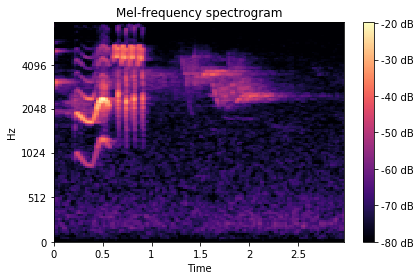

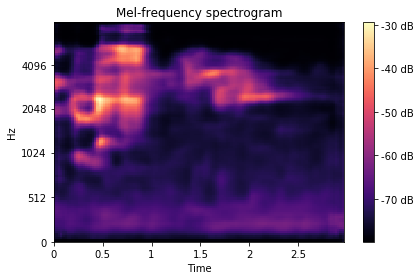

In [89]:
show_mapped_spectro(X_train[0]);
show_mapped_spectro(model(X_train[:1]));

In [90]:
def inverse_db_tensor(tensor):
    
    S_dB = unmap(tensor)
    
    S = librosa.db_to_power(S_dB)
    
    inv = librosa.feature.inverse.mel_to_audio(S)
    
    return inv

In [91]:
iground = inverse_db_tensor(X_train[0])
irecon = inverse_db_tensor(model(X_train[0:1]))

In [92]:
Audio(iground, rate=sample_rate)

In [93]:
Audio(irecon, rate=sample_rate)

---
## Interpolation using the latent space

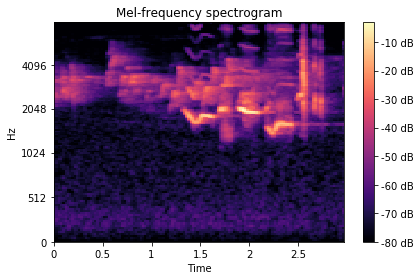

In [94]:
sample = X_train[700]

inversed = inverse_db_tensor(sample)
show_mapped_spectro(sample)
Audio(inversed, rate=sample_rate)

In [95]:
sample700 = X_train[700:701]

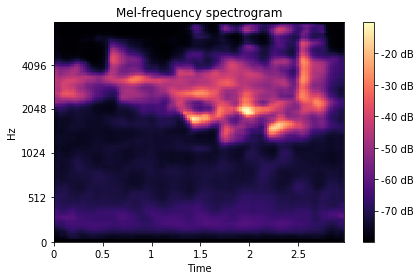

In [96]:
recon700 = model(sample700)
show_mapped_spectro(recon700);

In [97]:
inversed700 = inverse_db_tensor(recon700)
Audio(inversed700, rate=sample_rate)

In [98]:
latent700 = model.encode(sample700)

In [99]:
sample0 = X_train[0:1]

In [100]:
latent0 = model.encode(sample0)

In [101]:
midpoint = (latent0 + latent700) / 2

In [102]:
decoded = model.decode(midpoint)

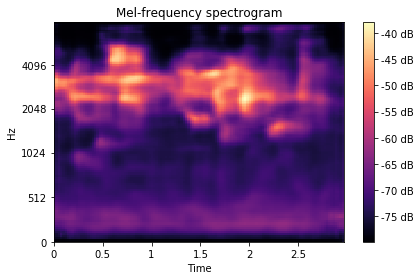

In [103]:
show_mapped_spectro(decoded);

In [104]:
invdecoded = inverse_db_tensor(decoded)
Audio(invdecoded, rate=sample_rate)

In [105]:
# Let's quickly try to sharpen

https://data-flair.training/blogs/image-processing-with-scipy-and-numpy/

In [106]:
from scipy import ndimage

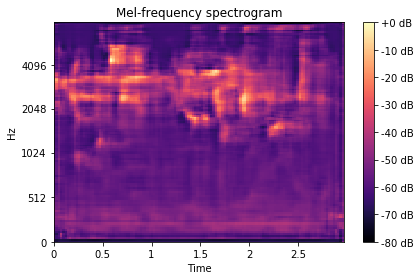

In [131]:
filter_blurred = ndimage.gaussian_filter(decoded,1)
alpha = 10
sharpened = decoded + alpha*(decoded - filter_blurred)
mapped = (sharpened - np.min(sharpened)) / (np.max(sharpened) - np.min(sharpened))

show_mapped_spectro(mapped);

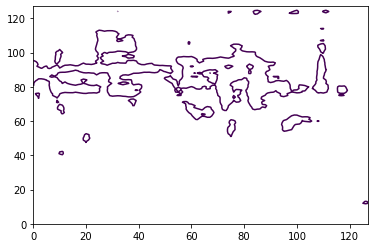

In [145]:
plt.contour(unmap(mapped), [-40, 0])

In [121]:
invsharp = inverse_db_tensor(sharpened)
Audio(invsharp, rate=sample_rate)

---
## Older work / staging area

Threatened birds in NA: https://www.birds-of-north-america.net/Threatened_Birds.html

Extinct birds in NA: https://www.birds-of-north-america.net/extinct-birds-of-north-america.html

Perhaps it would be interesting to make a point about birds going extinct.

https://www.xeno-canto.org/ allows searching for specific birds, so getting my data should be fine!

---

While I think of an artistic point, I should get started with the autoencoding.

[Tim Sainburg](https://github.com/timsainb/AVGN) recommends GAIA and Variational Autoencoder for generative use.

VAE: https://blog.keras.io/building-autoencoders-in-keras.html

Sainburg's models (includes VAE, GAIA, +): https://github.com/timsainb/tensorflow2-generative-models

TensorFlow Convolutional VAE tutorial: https://www.tensorflow.org/tutorials/generative/cvae

Music Autoencoders: https://blog.goodaudience.com/using-tensorflow-autoencoders-with-music-f871a76122ba

---
## I should use spectrograms instead perhaps...

https://www.tensorflow.org/tutorials/generative/cvae


https://github.com/tensorflow/docs/blob/master/site/en/r1/tutorials/sequences/audio_recognition.md

Use https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/wav_to_spectrogram to convert WAV to spectogram PNGs.

https://medium.com/red-buffer/autoencoders-guide-and-code-in-tensorflow-2-0-a4101571ce56

https://www.acoustics.asn.au/conference_proceedings/AAS2018/papers/p134.pdf

https://www.isca-speech.org/archive/interspeech_2015/papers/i15_1478.pdf